In [2]:
!uv add pandas

Resolved 39 packages in 357ms                                        
⠙ Preparing packages... (0/4)                                                   
⠙ Preparing packages... (0/4)----     0 B/338.46 KiB                    
tzdata     ------------------------------     0 B/338.46 KiB
⠙ Preparing packages... (0/4)----     0 B/5.14 MiB                      
tzdata     ------------------------------ 16.00 KiB/338.46 KiB
⠙ Preparing packages... (0/4)----     0 B/5.14 MiB                      
tzdata     ------------------------------ 32.00 KiB/338.46 KiB
⠙ Preparing packages... (0/4)----     0 B/5.14 MiB                      
tzdata     ------------------------------ 48.00 KiB/338.46 KiB
⠙ Preparing packages... (0/4)----     0 B/5.14 MiB                      
tzdata     ------------------------------ 61.03 KiB/338.46 KiB
⠙ Preparing packages... (0/4)----     0 B/5.14 MiB                      
tzdata     ------------------------------ 61.03 KiB/338.46 KiB
numpy      ------------------------

In [5]:
!uv add scikit-learn

Resolved 43 packages in 689ms                                        
⠙ Preparing packages... (0/4)                                                   
⠙ Preparing packages... (0/4)-------     0 B/17.98 KiB                  
⠙ Preparing packages... (0/4)--- 16.00 KiB/17.98 KiB                
threadpoolctl ------------------------------ 16.00 KiB/17.98 KiB
⠙ Preparing packages... (0/4)----     0 B/23.66 MiB                     
threadpoolctl ------------------------------ 16.00 KiB/17.98 KiB
joblib     ------------------------------     0 B/294.74 KiB
⠙ Preparing packages... (0/4)----     0 B/23.66 MiB                     
threadpoolctl ------------------------------ 17.98 KiB/17.98 KiB
joblib     ------------------------------     0 B/294.74 KiB
⠙ Preparing packages... (0/4)----     0 B/23.66 MiB                     
joblib     ------------------------------     0 B/294.74 KiB
⠙ Preparing packages... (0/4)----     0 B/23.66 MiB                     
joblib     --------------------------

In [33]:
!uv add matplotlib

Resolved 50 packages in 1.72s                                        
⠙ Preparing packages... (0/7)                                                   
⠙ Preparing packages... (0/7)----     0 B/105.19 KiB                    
⠙ Preparing packages... (0/7)---- 16.00 KiB/105.19 KiB                  
⠙ Preparing packages... (0/7)---- 32.00 KiB/105.19 KiB                  
⠙ Preparing packages... (0/7)---- 48.00 KiB/105.19 KiB                  
⠙ Preparing packages... (0/7)---- 64.00 KiB/105.19 KiB                  
⠙ Preparing packages... (0/7)---- 80.00 KiB/105.19 KiB                  
⠙ Preparing packages... (0/7)2m-- 96.00 KiB/105.19 KiB                  
pyparsing  ------------------------------ 96.00 KiB/105.19 KiB
⠙ Preparing packages... (0/7)----     0 B/7.67 MiB                      
kiwisolver ------------------------------     0 B/63.88 KiB
pyparsing  ------------------------------ 96.00 KiB/105.19 KiB
⠙ Preparing packages... (0/7)----     0 B/7.67 MiB                      
cycler

In [49]:
!uv add statsmodels

Resolved 52 packages in 1.18s                                        
⠙ Preparing packages... (0/2)                                                   
⠙ Preparing packages... (0/2)----     0 B/227.46 KiB                    
⠙ Preparing packages... (0/2)---- 14.88 KiB/227.46 KiB                  
⠙ Preparing packages... (0/2)---- 30.88 KiB/227.46 KiB                  
⠙ Preparing packages... (0/2)---- 46.88 KiB/227.46 KiB                  
⠙ Preparing packages... (0/2)---- 62.88 KiB/227.46 KiB                  
⠙ Preparing packages... (0/2)---- 78.88 KiB/227.46 KiB                  
⠙ Preparing packages... (0/2)---- 94.88 KiB/227.46 KiB                  
⠙ Preparing packages... (0/2)---- 110.88 KiB/227.46 KiB                 
⠙ Preparing packages... (0/2)---- 126.88 KiB/227.46 KiB                 
⠙ Preparing packages... (0/2)---- 142.88 KiB/227.46 KiB                 
⠙ Preparing packages... (0/2)---- 158.88 KiB/227.46 KiB                 
⠙ Preparing packages... (0/2)---- 174.88 KiB/2

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data/international-airline-passengers.csv")
df = df.iloc[:-1]
df.columns = ["month", "passengers_thousands"]

df["month"] = pd.to_datetime(df["month"], format="%Y-%m")

df.head()

,month,passengers_thousands
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [3]:
df.dtypes

month                   datetime64[ns]
passengers_thousands           float64
dtype: object

In [4]:
print(df["month"].min())
print(df["month"].max())

1949-01-01 00:00:00
1960-12-01 00:00:00


In [5]:
df.head()

,month,passengers_thousands
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [6]:
train_df = df[df["month"].dt.year<1960]
train_df.head()

,month,passengers_thousands
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [7]:
val_df = df[df["month"].dt.year==1960]
val_df.head()

,month,passengers_thousands
132,1960-01-01,417.0
133,1960-02-01,391.0
134,1960-03-01,419.0
135,1960-04-01,461.0
136,1960-05-01,472.0


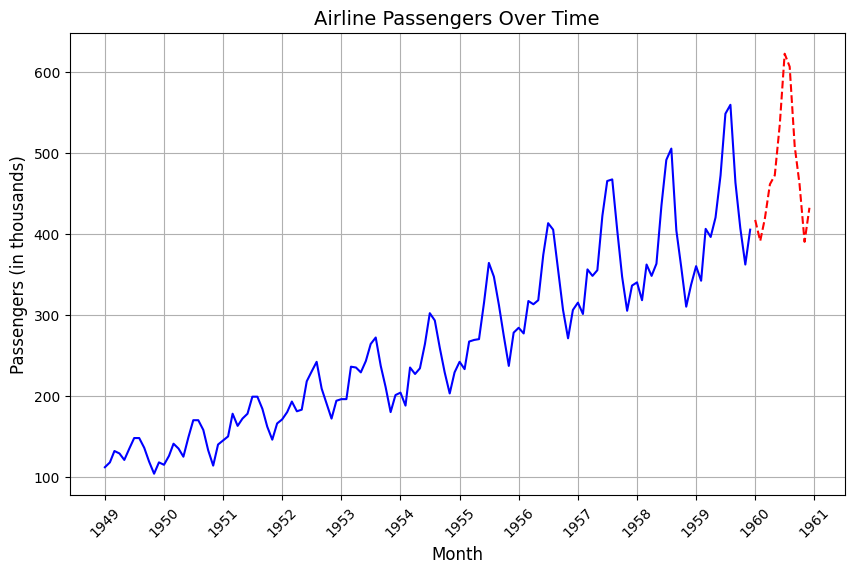

In [8]:
years = list(df["month"].dt.year.unique())
years.append(max(years) + 1)

plt.figure(figsize=(10, 6))
plt.plot(train_df["month"], train_df["passengers_thousands"], color="b")
plt.plot(val_df["month"], val_df["passengers_thousands"], color="r", linestyle="--")
plt.xticks(
    ticks=pd.to_datetime([f"{year}-01-01" for year in years]), 
    labels=years, 
    rotation=45  # Rotate for better readability if needed
)
plt.title("Airline Passengers Over Time", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Passengers (in thousands)", fontsize=12)
plt.grid(True)
plt.show()

## Create deseasonalized dataset

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

ADF Statistic: -3.048011
p-value: 0.030648
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


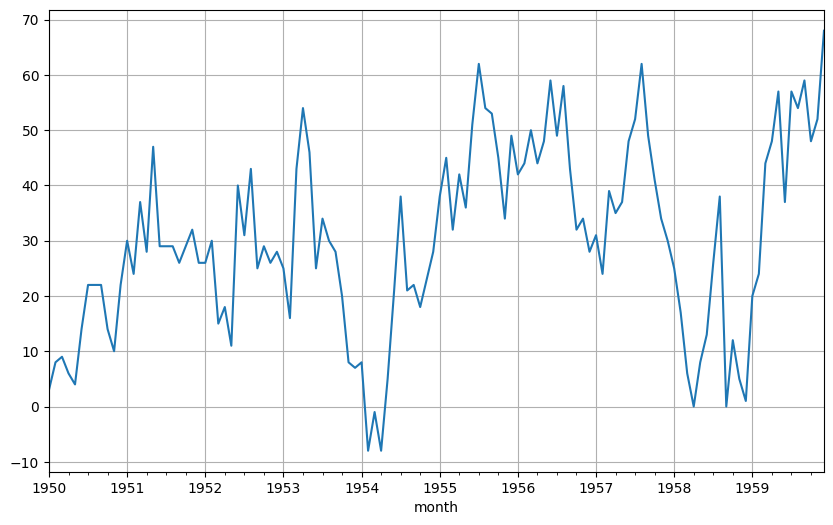

In [11]:
X = train_df["passengers_thousands"]
months_in_year = 12

stationary = difference(X, months_in_year)
stationary.index = train_df["month"][months_in_year:]

result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

plt.figure(figsize=(10, 6))
stationary.plot()
plt.grid(True)
plt.show()

In [12]:
# result = adfuller(train_df["passengers_thousands"])
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# #p < \alpha reject the null hypothesis (system has no unit root = stationary)
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.888027
p-value: 0.992932
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


## Select lag values for AR and MA

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

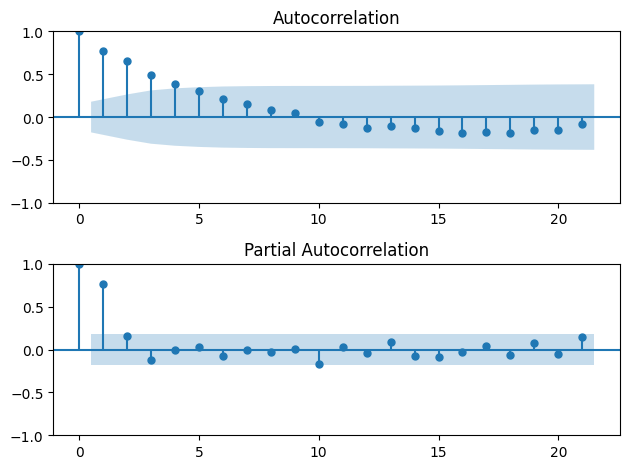

In [14]:
# Create a figure for subplots
plt.figure()

# Plot ACF (Autocorrelation Function) in the first subplot
plt.subplot(211)
plot_acf(stationary, ax=plt.gca())

# Plot PACF (Partial Autocorrelation Function) in the second subplot
plt.subplot(212)
plot_pacf(stationary, ax=plt.gca())

# Show the plots
plt.tight_layout()  # Ensure no overlapping between plots
plt.show()

## ARIMA

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from itertools import product

In [16]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [25]:
X = train_df["passengers_thousands"]
X.index = train_df["month"]

X

month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1959-08-01    559.0
1959-09-01    463.0
1959-10-01    407.0
1959-11-01    362.0
1959-12-01    405.0
Name: passengers_thousands, Length: 132, dtype: float64

In [32]:
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

In [34]:
history = [x for x in train]
predictions = []
months_in_year = 12  # Seasonal differencing interval

for i in range(len(test)):
    # Difference the data
    diff = difference(history, months_in_year)
    
    # Fit ARIMA model
    model = ARIMA(diff, order=(1, 0, 1))
    model_fit = model.fit()
    
    # Forecast one step ahead
    forecast = model_fit.forecast(steps=1)
    
    # Reverse differencing
    yhat = inverse_difference(history, forecast.iloc[0], months_in_year)
    predictions.append(yhat)
    
    # Observation
    obs = test[i]
    history.append(obs)
    print(f'>Predicted={yhat:.3f}, Expected={obs:.3f}')

>Predicted=353.660, Expected=347.000
>Predicted=311.477, Expected=305.000
>Predicted=340.272, Expected=336.000
>Predicted=345.464, Expected=340.000
>Predicted=327.320, Expected=318.000
>Predicted=375.937, Expected=362.000
>Predicted=358.871, Expected=348.000
>Predicted=359.968, Expected=363.000
>Predicted=432.321, Expected=435.000
>Predicted=479.728, Expected=491.000
>Predicted=492.110, Expected=505.000
>Predicted=439.347, Expected=404.000
>Predicted=355.913, Expected=359.000
>Predicted=318.925, Expected=310.000
>Predicted=345.515, Expected=337.000
>Predicted=345.817, Expected=360.000
>Predicted=336.981, Expected=342.000
>Predicted=385.796, Expected=406.000
>Predicted=386.824, Expected=396.000
>Predicted=406.648, Expected=420.000
>Predicted=485.980, Expected=472.000
>Predicted=527.893, Expected=548.000
>Predicted=554.873, Expected=559.000
>Predicted=453.576, Expected=463.000
>Predicted=412.330, Expected=407.000
>Predicted=355.854, Expected=362.000
>Predicted=384.864, Expected=405.000


RMSE: 12.662
MAE: 10.516


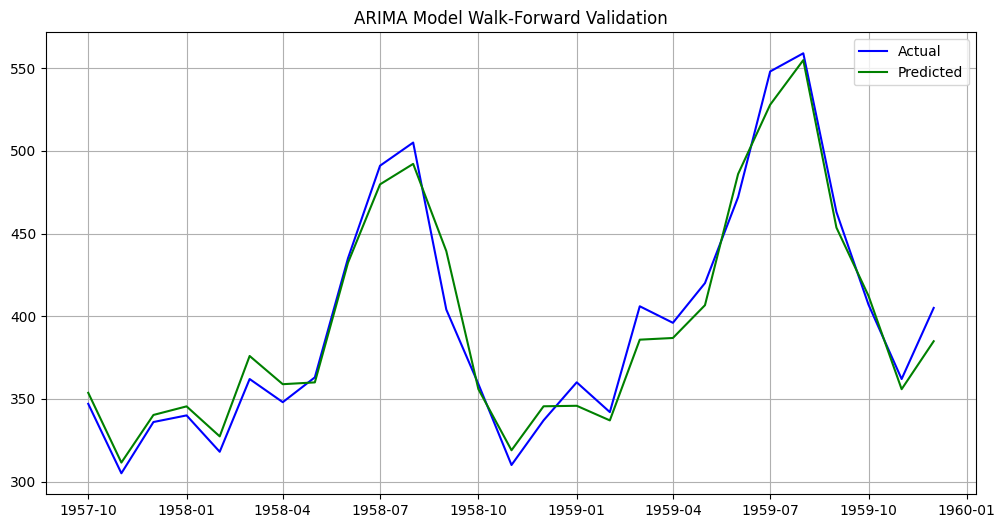

In [37]:
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = sqrt(mse)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test, label="Actual", color="blue")
plt.plot(test.index, predictions, label="Predicted", color="green")
plt.title("ARIMA Model Walk-Forward Validation")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
def evaluate_arima_model(X, arima_order, return_preds=False, validation=False):
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    months_in_year = 12

    predictions = []
    for t in range(len(test)):
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        yhat = forecast.predicted_mean.iloc[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    if return_preds:
        return test, predictions

    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

In [46]:
p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)

results = {}
for p, d, q in product(p_range, d_range, q_range):
    order = (p, d, q)
    rmse = evaluate_arima_model(X, order)
    results[order] = rmse
    print(f"Order {order}, RMSE: {rmse}")

Order (0, 0, 0), RMSE: 20.44119289127564
Order (0, 0, 1), RMSE: 16.03474448500369
Order (0, 0, 2), RMSE: 14.146867827658063
Order (0, 0, 3), RMSE: 12.892284121562017
Order (0, 1, 0), RMSE: 12.954335753515686
Order (0, 1, 1), RMSE: 12.940213948355337
Order (0, 1, 2), RMSE: 13.074519355605878
Order (0, 1, 3), RMSE: 12.957654464380385
Order (1, 0, 0), RMSE: 12.643366327399809
Order (1, 0, 1), RMSE: 12.66167884673632
Order (1, 0, 2), RMSE: 12.477491211313428
Order (1, 0, 3), RMSE: 12.657723174798011
Order (1, 1, 0), RMSE: 12.815013902663495
Order (1, 1, 1), RMSE: 12.776372248236495
Order (1, 1, 2), RMSE: 12.880998839651921
Order (1, 1, 3), RMSE: 13.105949625409803
Order (2, 0, 0), RMSE: 12.62485797946944
Order (2, 0, 1), RMSE: 12.741297543306105
Order (2, 0, 2), RMSE: 12.537240138889823
Order (2, 0, 3), RMSE: 12.65976803157613
Order (2, 1, 0), RMSE: 12.848654161798821
Order (2, 1, 1), RMSE: 12.865468703959962
Order (2, 1, 2), RMSE: 12.735547655764089
Order (2, 1, 3), RMSE: 13.2916906511538

In [48]:
best_order = min(results, key=results.get)
best_rmse = results[best_order]

print(f"\nBest Order: {best_order}, Lowest RMSE: {best_rmse}")


Best Order: (1, 0, 2), Lowest RMSE: 12.477491211313428


               0
count  27.000000
mean    1.017615
std    12.672822
min   -38.197029
25%    -5.784506
50%     2.560830
75%     8.569044
max    23.457425


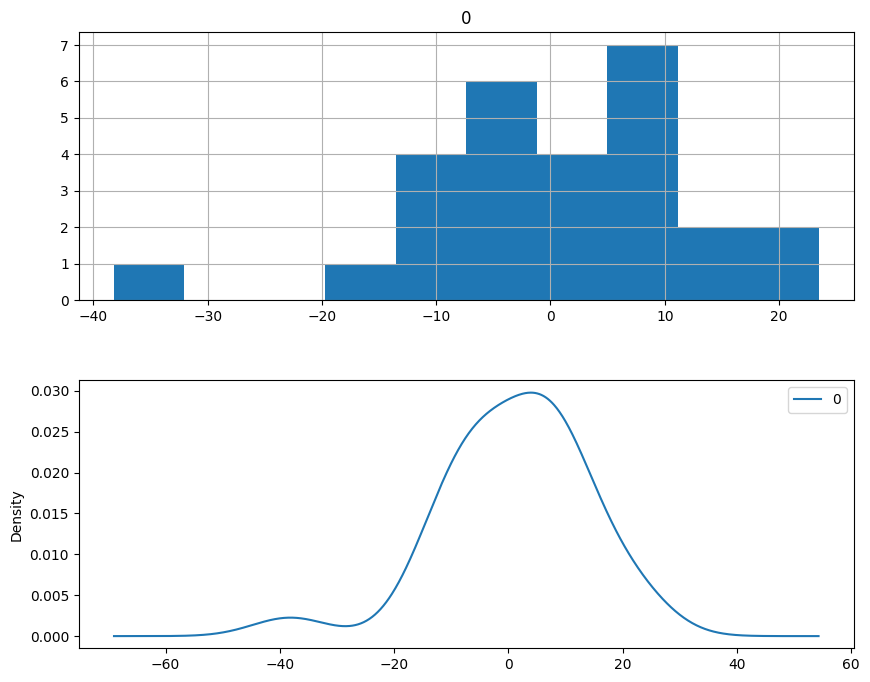

In [58]:
test, predictions = evaluate_arima_model(X, best_order, True)

residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

plt.figure(figsize=(10, 8))
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind="kde", ax=plt.gca())
plt.show()

Mean is near zero. Should be fine.

## Validation

In [60]:
val = val_df["passengers_thousands"]
val.index = val_df["month"]

In [62]:
len(val)

12

>Predicted=853.657, Expected=417.000
>Predicted=401.096, Expected=391.000
>Predicted=429.037, Expected=419.000
>Predicted=470.921, Expected=461.000
>Predicted=481.807, Expected=472.000
>Predicted=544.716, Expected=535.000
>Predicted=631.612, Expected=622.000
>Predicted=615.513, Expected=606.000
>Predicted=517.420, Expected=508.000
>Predicted=470.325, Expected=461.000
>Predicted=399.233, Expected=390.000
>Predicted=441.143, Expected=432.000
RMSE: 126.388


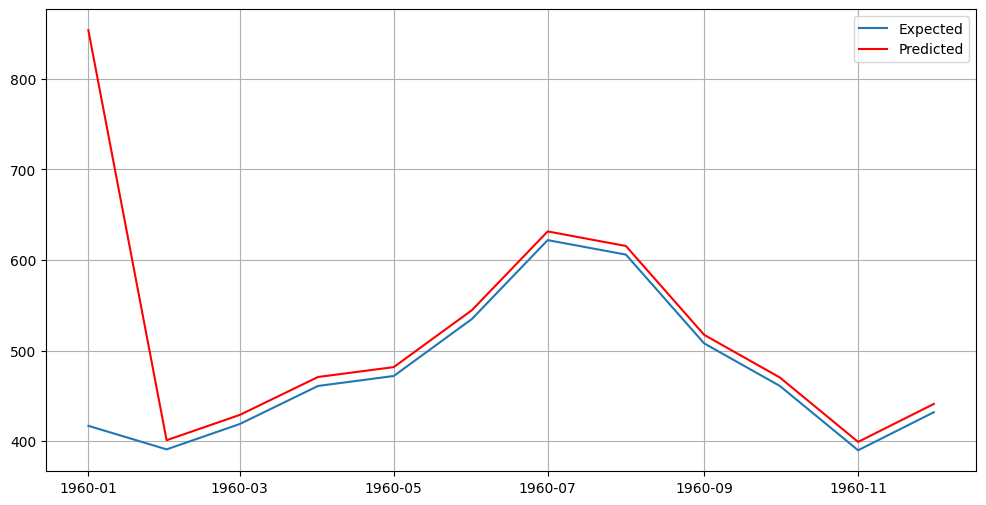

In [73]:
model = ARIMA(X, order=best_order)
model_fit = model.fit()

predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(val[0])
print(">Predicted=%.3f, Expected=%.3f" % (yhat, val[0]))

for i in range(1, len(val)):
    # Difference the data
    diff = difference(history, months_in_year)
    # Fit the ARIMA model
    model = ARIMA(diff, order=best_order)
    model_fit = model.fit()
    # Forecast
    yhat = model_fit.forecast().iloc[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    obs = val[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# Report performance
mse = mean_squared_error(val, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

predictions = pd.Series(predictions)
predictions.index = val.index

# Plot expected vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(val, label='Expected')
plt.plot(predictions, color='red', label='Predicted')
plt.legend()
plt.grid(True)
plt.show()